# Welcome to GPyEm!

GPyEm is a package used to create independent multi-output emulators for cohort emulation studies using GPyTorch.

In this tutorial we will go through the basics of generating emulators in GPyEm. 

# Installing GPyEm
## If you just want to use it...
```
pip install git+https://github.com/cwlanyon/GPyEm.git
```

## If you want to develop it...

Go to where you want to save your repo:
```
git clone https://github.com/cwlanyon/GPyEm.git
pip install -e GPyEm
```
So you can now import this in a python script anywhere you happen to be (no need to worry about paths etc):
```
from GPyEm import GPE_ensemble as GPE
```

## If you already have the repo on your computer...

Go to the location. E.g.
```
cd /home/me/Documents/code/GPyEm
```
Then call:
```
pip install -e .
```


# Discrepancy Emulators

GPyEm allows the creation of cohorts of emulators using a model whereby new cohort members learn from previous ones. A new emulator is generated by using a weighted sum over the cohort, so that
\begin{equation}
    g_i(\theta) = \sum_{n=1}^Na_ng_n(\theta)+\delta_c(\theta),
\end{equation}
this can be achieved in GPyEm by using the 'discrepancy_cohort' mean function and providing a number of reference emulators and a way to calculate the weights, $a_n$.

In this tutorial we'll compare six different discrepancy formulations:


$g_{\delta}:a=1$, discrepancy emulator with 1 reference emulator and $a=1$

$g_{\delta}:a=a_r$, discrepancy emulator with 1 reference emulator and $a$ learned via regression

$g_{\delta h}:a=a_h$, discrepancy emulator with 1 reference emulator and $a$ learned as a GPE hyperparameter  

$g_{\delta c}:\{a_n\}=\{a_{nh}\}$, discrepancy emulator with a full cohort of reference emulators and $\{a_n\}$ learned as GPE hyperparameters 

$g_{\delta c}:\{a_n\}=\{a_{nl}\}$, discrepancy emulator with a full cohort of reference emulators and $\{a_n\}$ learned using lasso regression 

$g_{\delta c}: \{a_n\}=\{a_{I}\}$, discrepancy emulator with a full cohort of reference emulators and $\{a_I\}\in\{a_n\}$  learned as GPE hyperparameters using lasso regression as an indicator function to select the subset 


In [1]:
# Import useful libraries
import math 
import torch 
import gpytorch # 
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pyDOE import *
import scipy.stats.qmc as qmc
import pandas as pd

# Import GPyEm
from GPyEm import GPE_ensemble as GPE 

seed=123

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

import scipy

First we generate a cohort of functions.

We will be emulating the function

$$ f(\theta)=-\sin(\theta-c)+b $$

where $\theta$ are the parameters and $a,b,c$ are latent variables specific to each cohort member.

In [2]:
nmesh=10 # The size of the cohort

In [3]:
latent_sampler = qmc.LatinHypercube(d=2)
latent_sample = latent_sampler.random(n=nmesh) #Sample the latent variables for the cohort

In [4]:
l_bounds = [-5,-1]
u_bounds = [5,1]
latent = qmc.scale(latent_sample, l_bounds, u_bounds) # Scale the latent variables for the cohort

In [5]:
theta_sampler = qmc.LatinHypercube(d=1) # Create a sampler for theta
l_bounds = [-5]
u_bounds = [5]


In [6]:
def fun(x,a,b,c): #Define f
    quad=-a*np.sin(x-c)+b
    return quad

In [19]:
# Generate our cohort

nsamp=50
inputs = []
outputs = []
for i,l in enumerate(latent):
    theta_sample = theta_sampler.random(n=nsamp)
    theta = qmc.scale(theta_sample, l_bounds, u_bounds)
    inputs.append(theta)
    outputs.append(fun(theta,1,l[0],l[1]))

Plot out cohort:

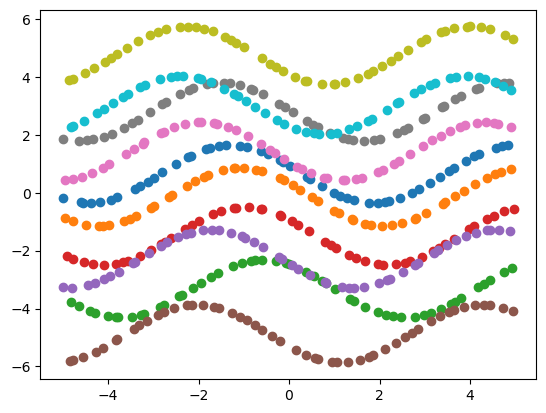

In [20]:
for i,j in enumerate(inputs):
    plt.plot(inputs[i],outputs[i],'o')

Then we train a cohort of emulators and save them in a list, as well as saving the training and testing data.

In [21]:
R2_mean = np.zeros((1,len(inputs)) )
R2_std = np.zeros((1,len(inputs))) 
emulators=[]
train_input=[]
train_output=[]
test_input=[]
test_output=[]
for i in range(len(inputs)):
    
    # split original dataset in training, validation and testing sets
    X=torch.tensor(inputs[i]).float()
    y=torch.tensor(outputs[i]).float()
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=seed
    )
    emulator=GPE.ensemble(X_train,y_train,mean_func='linear')
    mean,std=emulator.R2_sample(X_test,y_test,100)
    emulators.append(emulator)
    R2_mean[:,i]=mean
    R2_std[:,i]=std
    
    train_input.append(X_train)
    train_output.append(y_train)
    test_input.append(X_test)
    test_output.append(y_test)

0
0
0
0
0
0
0
0
0
0


In [22]:
R2_mean

array([[0.99985224, 0.99987334, 0.99986619, 0.99984413, 0.9998672 ,
        0.99936628, 0.9997943 , 0.99983811, 0.99988663, 0.99988002]])

Next we have to define some functions for our cohort emulators. 

First we define a lasso regression pipeline to learn possible values of $a_n$

In [23]:
model = Pipeline(steps=[
    #('scaler', StandardScaler()),
    ('preprocessor', PolynomialFeatures(degree=1, include_bias=False,interaction_only=False)),
    ('lasso', LassoCV(n_alphas=1000,max_iter=10000))
])

Next a function which standardises the predictions of each emulator

In [24]:
def m0_mat(y_test,emulators,x_test,output):

    m0=torch.zeros((y_test.shape[0],len(emulators)))
    for i in range(len(emulators)):
        m0[:,i]=(emulators[i].predict(x_test)[:,output]-y_train.mean(axis=0)[output])/y_train.std(axis=0)[output]


    return m0

Finally we define a proxy function to allow us to choose $a$ via a minimisation algorithm.

In [25]:
def proxy(a,y_train,m0,output):
    m_t = (m0-y_train.mean(axis=0))/y_train.std(axis=0)
    y_t = (y_train-y_train.mean(axis=0))/y_train.std(axis=0)
    a=torch.tensor(a)
    res = ((a*m_t-y_t)**2).mean(axis=0).detach().numpy()
    return res[output]

Now we can generate each of our six discrepancy emulators (+ a traditional emulator trained using the same number of points for comparison)

In [28]:
k=0 # Choose which cohort member we'd like to train as a discrepancy emulator
n=15 # Choose how many training points (max 16 if you've made no changes to the code above)
R2=torch.zeros(7,1) # Pre allocate the results matrix


emulators2=emulators.copy() # Make a copy of the emulator list so we can remove the chosen cohort member
emulators2.pop(k)

X_train = train_input[k] #Define training inputs and outputs
y_train = train_output[k]
X_test = test_input[k]
y_test = test_output[k]



# Randomly select n training points

X=X_train
y=y_train 
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    X,
    y,
    train_size=n,
    random_state=i
)

# Train a traditional emulator
model_f=GPE.ensemble(X_train1,y_train1,mean_func="linear",training_iter=500)
R2temp,R2std=model_f.R2_sample(X_test,y_test,1000)
R2[0]+=R2temp

# Train a discrepancy emulator with a randomly chosen reference and a=1
em=np.random.randint(len(emulators2))
model_dc_1 = GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=torch.tensor([[1],[1]]))
R2temp,R2std=model_dc_1.R2_sample(X_test,y_test,1000)
R2[1]+=R2temp



# Train a discrepancy emulator with a randomly chosen reference and a learned by regression
m0 = emulators2[em].predict(X_train1)
a_d=np.zeros((y_train.shape[1],1))
for l in range(y_train.shape[1]):
    result = scipy.optimize.minimize(proxy, 1, args=(y_train1,m0,l), method='Nelder-Mead', tol=1e-8)
    a_d[l]=result.x
a_d=torch.tensor(a_d)
model_dc_reg = GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]],a=a_d)
R2temp,R2std=model_dc_reg.R2_sample(X_test,y_test,1000)
R2[2]+=R2temp


# Train a discrepancy emulator with a randomly chosen reference and a learned as a hyperparameter
model_dc_learned = GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=[emulators2[em]])

R2temp,R2std=model_dc_learned.R2_sample(X_test,y_test,1000)
R2[3]+=R2temp


# Train a discrepancy emulator with the full cohort as references and a_n learned as  hyper-parameters
model_dc_all = GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2)

R2temp,R2std=model_dc_all.R2_sample(X_test,y_test,1000)
R2[4]+=R2temp/(len(emulators))


# Train a discrepancy emulator with the full cohort as references and a_n learned via lasso regression
a_d=torch.zeros((y_train1.shape[1],len(emulators2)))
for j in range(y_train1.shape[1]):
    m0=m0_mat(y_train1,emulators2,X_train1,j)
    # fit to an order-3 polynomial data
    y_t=(y_train1[:,j]-y_train1.mean(axis=0)[j])/y_train1.std(axis=0)[j]
    model = model.fit(m0.detach().numpy(), y_t.detach().numpy())
    a_d[j]=torch.tensor(model.named_steps['lasso'].coef_)


model_dc_lasso=GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d)
R2temp,R2std=model_dc_lasso.R2_sample(X_test,y_test,1000)
R2[5]+=R2temp


# Train a discrepancy emulator with the full cohort as references and lasso regression used as an indicator function
model_dc_lasso_learned=GPE.ensemble(X_train1,y_train1,mean_func="discrepancy_cohort",training_iter=500,ref_emulator=emulators2,a=a_d,a_indicator=True)

R2temp,R2std=model_dc_lasso_learned.R2_sample(X_test,y_test,1000)
R2[6]+=R2temp


0
0
0
0
0
0
0


In [36]:
results=pd.DataFrame((R2))

results.index=['$g_1$','$g_{\delta}:a=1$','$g_{\delta}:a=a_r$','$g_{\delta h}:a=a_h$','$g_{\delta c}:\{a_n\}=\{a_{nh}\}$','$g_{\delta c}:\{a_n\}=\{a_{nl}\}$','$g_{\delta c}:\{a_n\}=\{a_{I}\}$']

results.columns=['$R^2$']

results.round(3)

,$R^2$
$g_1$,0.998
$g_{\delta}:a=1$,0.986
$g_{\delta}:a=a_r$,0.998
$g_{\delta h}:a=a_h$,0.998
$g_{\delta c}:\{a_n\}=\{a_{nh}\}$,0.092
$g_{\delta c}:\{a_n\}=\{a_{nl}\}$,0.999
$g_{\delta c}:\{a_n\}=\{a_{I}\}$,0.999
